<a href="https://colab.research.google.com/github/DanieloSendi/Deep-Learning-Labs/blob/main/04_ConvNet2_Data_Augmentation_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ConvNet 2**

***
## **Introduction - ConvNet for small dataset**
***

Having to train an image classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. A “few” samples can mean anywhere from a few hundred to a few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats, in a dataset containing 4,000 pictures of cats and dogs (2,000 cats, 2,000 dogs). We’ll use 2,000 pictures for training – 1,000 for validation, and 1,000 for testing.

### 1. Import and install libraries

In [1]:
from tensorflow.keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
# This is module with image preprocessing utilities
from keras.preprocessing import image

import math

import shutil
import os

In [2]:
# # Use below code to upload your kaggle.json to colab environment (you can download kaggle.json from your Profile->Account->API Token)
! pip install -q kaggle --quiet

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### 2. Dataset configuration

Download the original dataset at [kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) (create a Kaggle account if you don't already have one).

This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is ~800MB large (compressed). After downloading and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation set with 500 samples of each class, and finally a test set with 500 samples of each class.

As we only need 4000 images, you do not need to download the whole dataset. You can download only train set (~500MB large).

If you use Google Colab and don't want to download the whole dataset on your computer, you can link a Kaggle account with Colab. For further information see link below: https://www.kaggle.com/general/74235

In [3]:
# Define paths
kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_creds_path = "/content/drive/MyDrive/GitHub/Deep-Learning-Lab/kaggle.json"

# Create ~/.kaggle directory if it doesn't exist
if not os.path.exists(kaggle_dir):
    os.mkdir(kaggle_dir)

# Copy kaggle.json to ~/.kaggle
shutil.copy(kaggle_creds_path, kaggle_dir)

# Set the right permissions for kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Define the competition name
name_of_competition = "dogs-vs-cats"

# Check if train.zip exists
if os.path.exists("train.zip"):
    print("File already exists. Skipping download.")
else:
    # Download the dataset
    print("Downloading dataset...")
    !kaggle competitions download -c {name_of_competition} -f train.zip

    !mkdir -p /content/dogs-vs-cats/original

    # Check if the file was downloaded successfully
    if not os.path.exists("train.zip"):
        print("Failed to download train.zip. Check your Kaggle credentials or competition name.")
    else:
        print("Dataset downloaded successfully!")

# Extract the dataset if the file exists and suppress the output
if os.path.exists("train.zip"):
    print("Extracting dataset...")
    # !unzip train.zip > /dev/null 2>&1
    !unzip -q /content/train.zip -d /content/dogs-vs-cats/original
    print("Dataset extracted successfully!")

 99% 540M/543M [00:16<00:00, 37.2MB/s]
100% 543M/543M [00:16<00:00, 35.0MB/s]
Dataset downloaded successfully!
Extracting dataset...
Dataset extracted successfully!


After downloading the data, you have to arrange them correctly in the catalogues. Data should be split into separate catalogs for dogs and for cats. You can do it manually or in python (for example using `os` and `shutil` libraries.

```bash
main_directory/
...train/
......class_a/
.........a_image_1.jpg
.........a_image_2.jpg
......class_b/
.........b_image_1.jpg
.........b_image_2.jpg
...validation/
......class_a/
.........a_image_1.jpg
.........a_image_2.jpg
......class_b/
.........b_image_1.jpg
.........b_image_2.jpg
```

Check the train/validation/test datasets. We now have 2000 training images, then 1000 validation images and 1000 test images (optional). In each split, there is the same number of samples from each class. This is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.

In [5]:
# The path to the directory where the original dataset was uncompressed
original_dataset_dir = '/content/dogs-vs-cats/original/train'

# The directory where we will store our smaller dataset
base_dir = '/content/dogs-vs-cats/small'
os.makedirs(base_dir, exist_ok=True)


# Directories for our training,
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

# Directories for our validation
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

# Directories for our test splits
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

***
## **Part 1 Data Augmentation**
***

Data augmentation takes the approach of generating more training data from existing training samples, by “augmenting” the samples via a number of random transformations that yield believable-looking images. The common-sense approach would be the manual creation of more images and applying small changes. However, it can be done easier and more efficiently in Keras, using ImageDataGenerator.

The goal is that at training time, our model would never see the exact same picture twice. It will change each image at the loading stage. This helps the model get exposed to more aspects of the data and generalize better. Below you can see an example. Where before we use only the rescale parameter, there are now several other random transformations:

```python
datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
```

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

- `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
- `width_shift` and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally – relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

### 3. Data preprocessing

Data preprocessing steps include the following:

- Read the picture files.
- Decode the JPEG content to RBG grids of pixels.
- Convert these into floating-point tensors.
- Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

In [6]:
batch_size = 20

# For training dataset
train_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(150,150),
    shuffle=True,
)

# For validation dataset
val_dataset = image_dataset_from_directory(
    validation_dir,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(150,150),
    shuffle=True,
)

# For test dataset
test_dataset = image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(150,150),
    shuffle=False,
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [7]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 1)


In [8]:
# Apply Rescaling to all datasets
rescale = layers.Rescaling(1.0 / 255)

val_dataset = val_dataset.map(
    lambda x, y: (rescale(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.map(
    lambda x, y: (rescale(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

#### Augmentation

> **Notice**
>
> If you load images using `image_dataset_from_directory` you can't do the augmentation while loading. Instead, you have to do Random layers as the first layers of your model. See documentation below.
>
> [RadnomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation)
[RandomWidth](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomWidth)

In [9]:
# Create data augmentation as a separate model
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.4),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(0.2, 0.2),
    ]
)

In [10]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)


train_dataset = train_dataset.map(
    lambda x, y: (rescale(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [11]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In the next steps of the instruction is visualise augmented data. It would require seting parameter`data_augmentation.training = True`, then calling `data_augmentation.predict(…)` on a single image/batch.

Let's take a look at our augmented images:

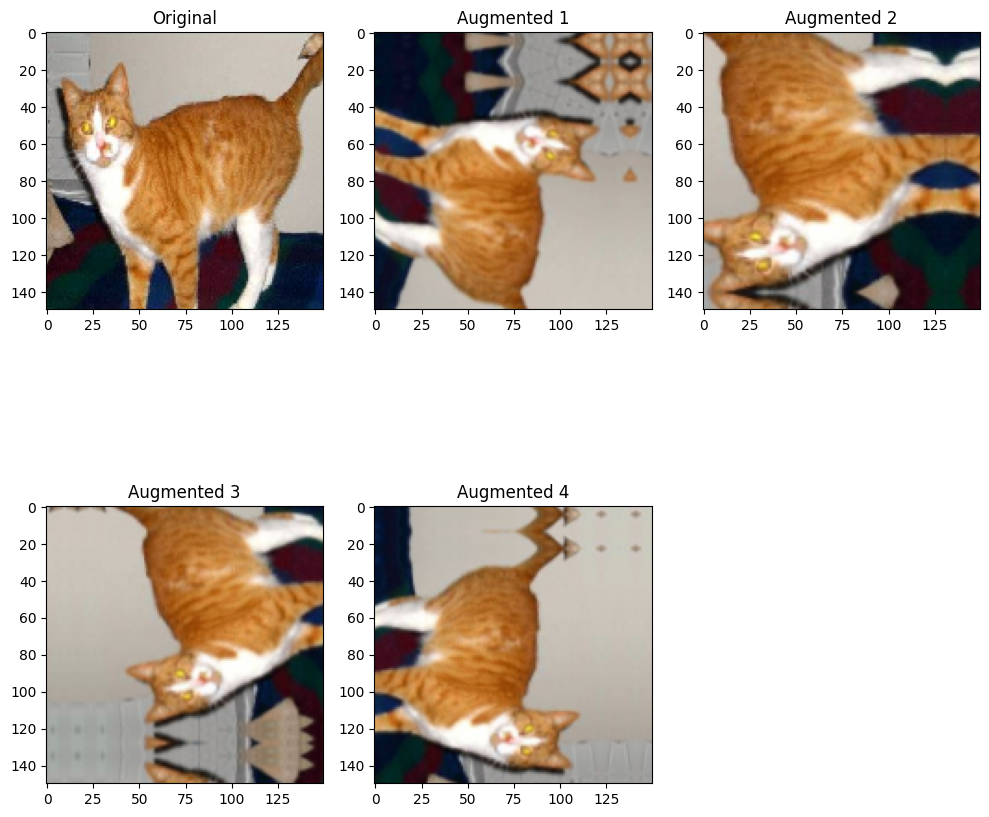

In [12]:
# This is module with image preprocessing utilities
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)
# x = tf.expand_dims(x, axis=0)

augmented_images = [data_augmentation(x, training=True)[0].numpy() for _ in range(4)]

plt.figure(figsize=(10, 10))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.axis("on")
plt.title("Original")

for i, aug_img in enumerate(augmented_images):
    plt.subplot(2, 3, i + 2)
    plt.imshow(aug_img / 255.0)
    plt.axis("on")
    plt.title(f"Augmented {i + 1}")

plt.tight_layout()
plt.show()

### 4. Network Architecture

You've already built a small convnet for MNIST in the previous exercise. You will reuse the same general structure: our convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one more Conv2D + MaxPooling2D stage. This serves both to augment the capacity of the network and to further reduce the size of the feature maps so that they aren't overly large when we reach the Flatten layer. Here, since we start from inputs of size 150×150 (a somewhat arbitrary choice), we end up with feature maps of size 7×7 right before the Flatten layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 148×148 to 7×7). This is a pattern that you will see in almost all convnets. Since we are attacking a binary classification problem, we are ending the network with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the network is looking at one class or the other.

Create network architecture based on the information above (<ins>4x Conv2d, 4x Maxpooling layers and then Flatten, 2 x Dense layer</ins>).

Model summary should look like this:

In [13]:
model = models.Sequential()

model.add(layers.Input(shape=(150, 150, 3)))
# Nest data augmentation model as a layer
model.add(data_augmentation)

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

### 5. Training model

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images, so the results won't be that much better.

Let's fit our model to the dataset. We may pass a validation_data argument.

Note, that this time we train the network longer (for about 100 epochs) and it still increases. If training takes too much time on your machine, you can try lower numbers.

In [15]:
steps_per_epoch = len(train_dataset)
validation_steps = len(val_dataset)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 100
Validation steps: 50


In [16]:
history = model.fit(
      train_dataset,
      epochs=100,
      validation_data=val_dataset,
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.4937 - loss: 0.7499 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.4902 - loss: 0.6939 - val_accuracy: 0.4990 - val_loss: 0.6939
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.5159 - loss: 0.6945 - val_accuracy: 0.5150 - val_loss: 0.6921
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.5509 - loss: 0.6914 - val_accuracy: 0.5680 - val_loss: 0.6876
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.5442 - loss: 0.6894 - val_accuracy: 0.5530 - val_loss: 0.6879
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.5686 - loss: 0.7073 - val_accuracy: 0.5220 - val_loss: 0.6932
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.5712 - loss: 0.6812 - val_accuracy: 0.5340 - val_loss: 0.6750
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.5646 -

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

### 6. Outcome analysis

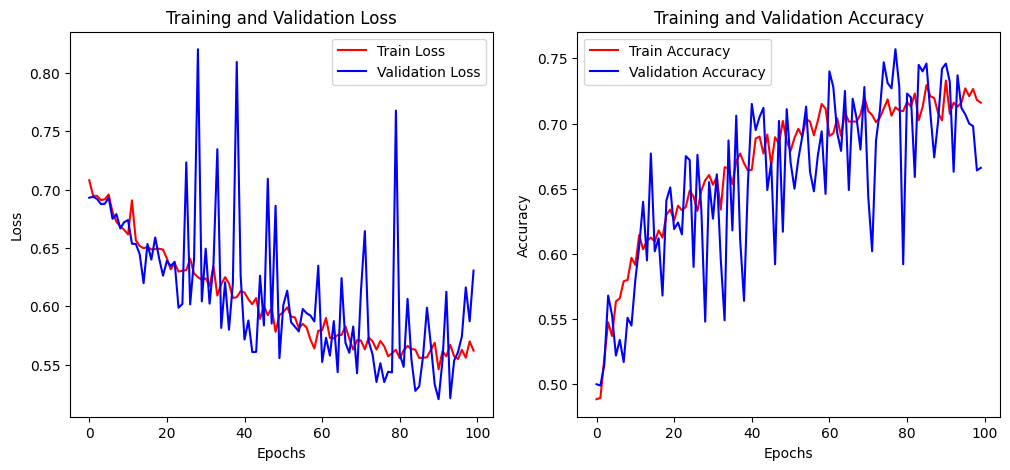

In [18]:
history_dict = history.history
training_loss = history_dict['loss']
validation_loss = history_dict['val_loss']
training_accuracy = history_dict['accuracy']
validation_accuracy = history_dict['val_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(training_loss, label='Train Loss', color='red')
axes[0].plot(validation_loss, label='Validation Loss', color='blue')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(training_accuracy, label='Train Accuracy', color='red')
axes[1].plot(validation_accuracy, label='Validation Accuracy', color='blue')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# plt.tight_layout()
plt.show()

### 7. Evaluate the model on the test data

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4814 - loss: 0.9420
Test Loss: 0.6666
Test Accuracy: 0.6470


#### Model save

In [20]:
model.save('catvsdogs_aug.keras')

# Loading a model from file
# load_saved_model = tf.keras.models.load_model('catvsdogs.keras')

# Show the model architecture
# load_saved_model.summary()

***
## **Part 2 Adding Dropout Layer**
***

In [21]:
base_dir = 'dogs-vs-cats/small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

A dropout layer is a very simple, yet quite counter-intuitive method. What it does is basically cutting off half of the connection between the layers. You may ask yourself a question - Why do I train the network so hard, only to randomly throw half of the information away? Surprisingly, this works. In many situations network is overfitting to the data so much, that randomly cutting 20%, 30%, or even 50% of connection during training phase will be beneficial.

Therefore, to further combat overfitting, we will also add a Dropout layer to our Dogs and Cats example. Please configure the model with the same four convolutional layers and four max-pooling layers like last week, but this time add the Dropout layer right before the densely-connected classifier (with parameter 0.5).

### 1. Data preprocessing

In [22]:
datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [23]:
batch_size = 20

# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


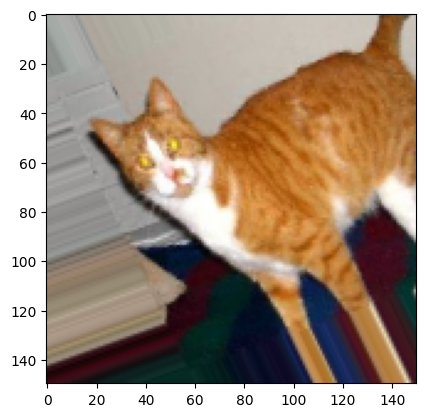

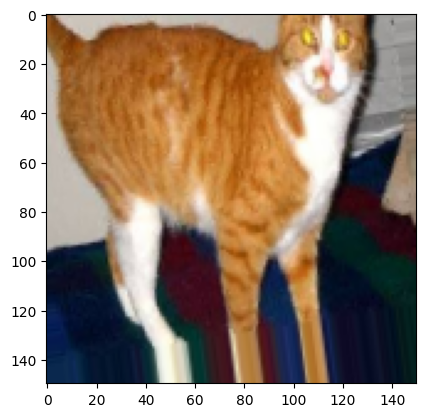

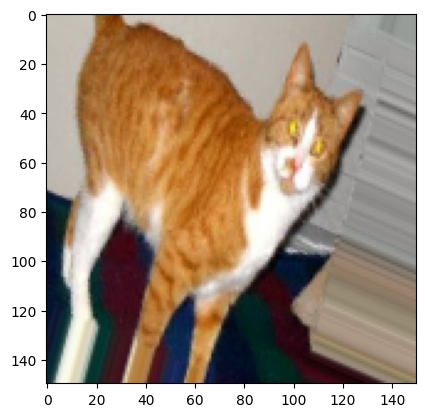

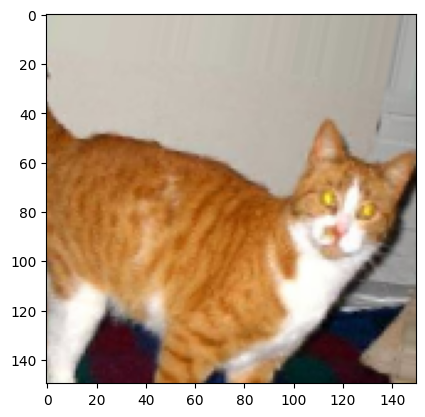

In [24]:
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [25]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


### 2. Network architecture

In [26]:
model2 = models.Sequential()

model2.add(layers.Input(shape=(150, 150, 3)))

model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

### 3. Training

In [27]:
model2.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [28]:
history2 = model2.fit(
      train_generator,
      epochs=100,
      validation_data=validation_generator,
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.4791 - loss: 0.7857 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 0.4951 - loss: 0.6976 - val_accuracy: 0.5980 - val_loss: 0.6920
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.5405 - loss: 0.6927 - val_accuracy: 0.6080 - val_loss: 0.6696
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.5472 - loss: 0.6829 - val_accuracy: 0.5990 - val_loss: 0.6553
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.5962 - loss: 0.6582 - val_accuracy: 0.6130 - val_loss: 0.6408
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.5885 - loss: 0.6597 - val_accuracy: 0.6640 - val_loss: 0.6170
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.6335 - loss: 0.6410 - val_accuracy: 0.6470 - val_loss: 0.6292
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.6330 - loss: 0.639

### 4. Outcome analysis

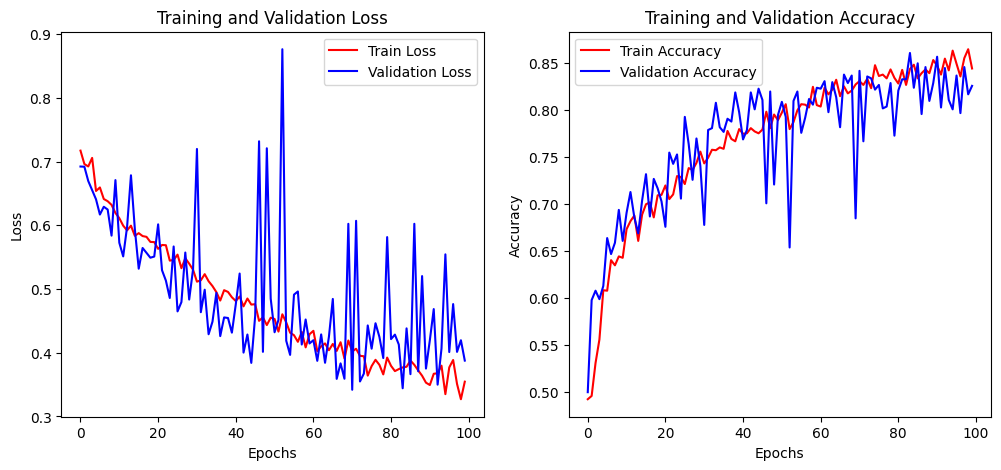

In [29]:
history2_dict = history2.history
training_loss = history2_dict['loss']
validation_loss = history2_dict['val_loss']
training_accuracy = history2_dict['accuracy']
validation_accuracy = history2_dict['val_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(training_loss, label='Train Loss', color='red')
axes[0].plot(validation_loss, label='Validation Loss', color='blue')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(training_accuracy, label='Train Accuracy', color='red')
axes[1].plot(validation_accuracy, label='Validation Accuracy', color='blue')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# plt.tight_layout()
plt.show()

### 5. Evaluation on the test data

In [30]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [31]:
test_loss, test_acc = model2.evaluate(test_generator)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8012 - loss: 0.4725
Test Loss: 0.4442
Test Accuracy: 0.8030


#### Save model

In [32]:
model.save('catvsdogs_part2_dropout_aug.keras')

#Loading a model from file
# load_saved_model = tf.keras.models.load_model('catvsdogs_part2_dropout_aug.keras')

# Show the model architecture
# load_saved_model.summary()

If you want, you can also try training the model with a dropout layer, but without image augmentation, to see which one is better. Both methods should give better results than training without any of them, but worse than having them combined. You may, however, notice, that dropout is faster. If you want, you can change the dropout parameter. Maybe we cut off too much? You can also try to experiment with putting the dropout layer in different places (maybe between convolutions), or even adding more dropout layers. There is hardly ever one universal way to implement a model.